# HyperLogLog

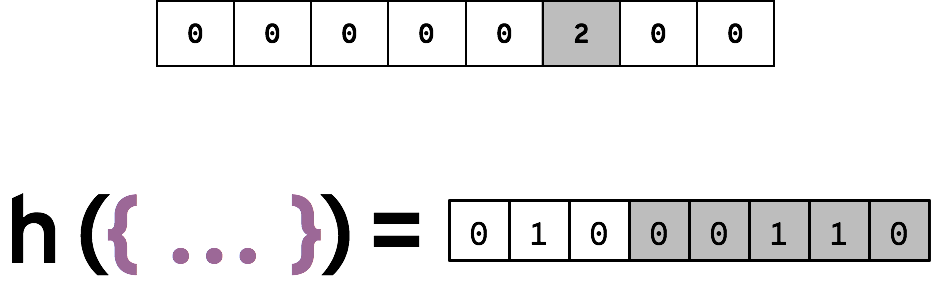

HyperLogLog is trickier to understand than Bloom filters or count-min sketch, so let's start with some intuitions.

If we have a source from which we can sample uniformly-distributed _n_-bit integers, we can also see it as a source for drawing _n_ coin flips -- each bit in an integer sampled from the population of uniformly-distributed _n_-bit integers is independent of the others and is equally likely to be true or false.

Because each bit is independent and equally likely to be true or false, runs of consecutive bits with the same value become increasingly unlikely with length.  The probability of seeing _n_ consecutive zeros, for example, is $1$ in $2^n$.  Similarly, if the largest number of leading zeros we've seen in a stream of random numbers is _n_, we can estimate that we've seen $2^n$ numbers.

To see this in action, let's sample some random numbers and plot the distribution of leading-zero counts.  We'll start by importing the libraries we need (`numpy` and plotting support):



We'll start with a function to count leading zeros:

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
def leading_zeros(bs):
    """ Return the index of the leftmost one in an 
        integer represented as an array of bytes """
    first = 0
    for b in bs:
        if b == 0:
            first += 8
        else:
            for bit in range(7, -1, -1):
                if ((1 << bit) & b) > 0:
                    return first
                else:
                    first += 1
    return first

We'll then generate some 32-bit random integers and plot the distribution of leading-zero counts.

In [ ]:
def lz_experiment(ct):
    from numpy.random import randint as ri
    result = []
    for _ in range(ct):
        result.append(leading_zeros(bytes([ri(255), ri(255), ri(255), ri(255)])))

    return result

lz = lz_experiment(4096)

sns.distplot(lz, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))

As we can see from inspecting the cumulative distribution plot, about 50% of the samples have no leading zeros, about 75% have one or fewer leading zeros, about 87.5% of samples have two or fewer leading zeros, and so on.

In [ ]:
from hashlib import sha1
import pickle

def h64(v):
    bvalue = type(v) == bytes and v or pickle.dumps(v)
    return int.from_bytes(sha1(bvalue).digest()[:8], 'little')

def get_alpha(p):
    return {
        4: 0.673,
        5: 0.697,
        6: 0.709,
    }.get(p, 0.7213 / (1.0 + 1.079 / (1 << p)))

def first_set_bit(i, isize):
    return isize - i.bit_length() + 1

class HLL(object):
    def __init__(self, p=4):
        self.p = min(max(p, 4), 12)
        self.m = int(2 ** self.p)
        self.alpha = get_alpha(self.p)
        self._registers = np.zeros(self.m, np.uint8)
        self._zeros = self.m
    
    def add(self, v):
        h = h64(v)
        idx = h & (self.m - 1)
        h >>= self.p
        fsb = first_set_bit(h, 64 - self.p)
        if self._zeros > 0 and self._registers[idx] == 0 and fsb > 0:
            self._zeros -= 1
        self._registers[idx] = max(self._registers[idx], fsb)
    
    def approx_count(self):
        from math import log
        from scipy.stats import hmean
        
        if self._zeros > 0:
            # if we have empty registers (and thus probably a small set),
            # use a different approximation that will be more precise
            return self.m * math.log(float(self.m) / self._zeros)
        else:
            # return the harmonic mean of 2 to the power of every register, 
            # scaled by the number of registers
            return self.alpha * self.m * hmean(np.power(2.0, self._registers))

In [ ]:
hll = HLL()

import random

for i in range(20000):
    hll.add(random.getrandbits(64).to_bytes(8, "big"))

hll.approx_count()

Like Bloom filters and count-min sketches, HyperLogLog estimates can also be added together so that you can summarize large data sets in parallel.  To combine two HyperLogLog estimates with the same number of registers, simply take the maximum of each pair of registers with the same index.  (As an easy exercise, implement this above and convince yourself that it works the same as using a single estimate for a large stream.)

If you're interested in learning more about HyperLogLog, a great place to start is ["HyperLogLog in Practice:  Algorithmic Engineering of a State of The Art Cardinality Estimation Algorithm"](https://research.google.com/pubs/pub40671.html).  As an exercise, try implementing some of their techniques to improve the performance of the code above!